### **Seq2Seq**

### **입력 시퀀스를 일정 길이의 출력 시퀀스로 변환하는 모델을 의미**
- 기계번역, 텍스트 요약등 시퀀스 데이터를 사용함

Encoder, Decoder로 이루어져있음 RNN, LSTM, GRU 등의 시퀀스 모델을 사용
1개의 RNN 모델이 모든 시점을 처리하며 모든 시점에서의 파라미터($W_1, W_2, W_3$)는 같음
Encoder, Decoder에 사용되는 RNN는 각각 개별 모델임

SOS(Start of Sentence) : 문장의 시작 토큰
- 번역 시작을 알리는 신호

EOS(End of Sentence) : 문장의 끝 토큰
- 모델이 언제 번역을 멈춰야 할지 학습, 가변 길이의 출력을 다루는데 필수적

### **1. Encoder : 입력 시퀀스(문장)를 받아 이를 고정된 길이의 Context Vector로 변환**   

Context Vector란 Encoder가 입력 시퀀스를 처리한 후 마지막 은닉 상태를 고정된 크기의 벡터로 표현한 것
- Encoder에서 입력 시퀀스의 정보를 압축한 것으로 입력 문장의 전체 맥락 정보를 담고 있으며 디코더가 번역문을 생성할 때 참조하는 핵심 정보

1. Embedding: 입력 시퀀스를 벡터화하여 모델이 이해할 수 있는 형태로 변환
2. RNN 계층: 벡터화된 입력 데이터를 RNN, LSTM, GRU 등의 계층에 전달하여 순차적으로 처리합니다.
3. 마지막 은닉 상태($hr$)를 Context Vector로 사용하며 입력 시퀀스의 정보를 압축

### **2. Decoder : 인코더가 생성한context vector를 사용하여 이전 출력과 현재 입력을 기반으로 출력 시퀀스 출력**
- Encoder에서 전달된 context vector를 초기 hidden state와 cell state로 사용.
- 이전 시점의 출력 토큰을 입력으로 받아 다음 단어를 예측.
- SOS 토큰으로 시작하여 각 시점마다 순차적으로 다음 토큰을 생성하며, EOS 토큰을 만나면 번역을 종료

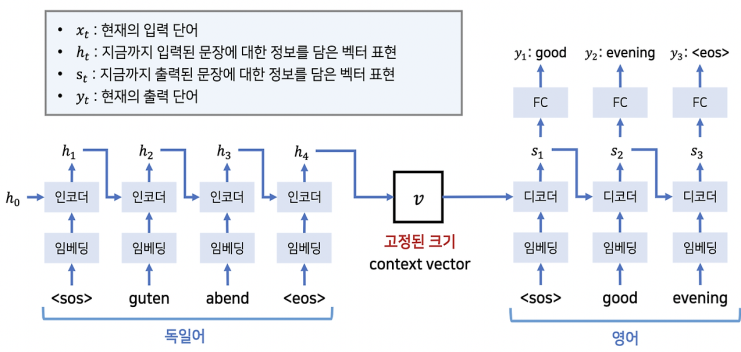

In [3]:
import torch
import torch.nn as nn


# 1. 입력 x : [batch_size, seq_len] ex) 독일어 문장 "<sos> guten abend <eos>" → [1, 123, 456, 2].
# 2. Embedding 출력 : [batch_size, seq_len, embedding_dim]
# 3. LSTM 출력 : [batch_size, seq_len, hidden_dim], hidden : [num_layer, batch_size, hidden_dim], cell : [num_layer, batch_size, hidden_dim]

class Encoder(nn.Module):
    def __init__(self, num_vocabs, em_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        
        # 임베딩 레이어 정의 (number of vocabs embedding dimension), num_vocabs : 단어 사전의 크기(문서에 등장하는 단어의 개수), em_dim : 임베딩 차원
        self.embedding = nn.Embedding(num_vocabs, em_dim)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)

        # LSTM 셀로 hidden, cell state 생성
        # batch_first=False: 입력 데이터 형식은 (seq_len, batch_size, input_size)
        self.lstm = nn.LSTM(em_dim, hidden_dim, num_layers = num_layers, dropout = dropout)
        
    def forward(self, x):
        # batch_first = False이면 차원이 (seq_len, batch_size, em_dim)로 lstm에 입력되야하기 때문에 차원순서 바꿔야함  (batch_size, seq_len, em_dim) => (seq_len, batch_size, em_dim)
        embedded  = self.embedding(x).permute(1, 0, 2)

        outs = self.dropout(embedded)
        outs, (h, c) = self.lstm(outs)
        
        # h,c => context vector로 decoder에 전달해야하기 때문에 h, c 출력
        return h, c    
    
    


In [ ]:
# 1. 입력 x : [batch_size] ex) 영어 시작 단어 "<sos>" → [1]
# 2. 차원 확장 : [batch_size] -> [batch_size, 1]
# 3. Embedding 적용 : [batch_size, 1, embedding_dim]
# 4. LSTM 출력 : [batch_size, 1, hidden_dim], hidden : [num_layer, batch_size, hidden_dim], cell : [num_layer, batch_size, hidden_dim]
# 5. 차원 축소 : [batch_size, 1, hidden_dim] -> [batch_size, hidden_dim]
# 6. fc layer 적용 후 출력 : [batch_size, num_vocabs]

class Decoder(nn.Module):
    def __init__(self, num_vocabs, em_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        
        # 출력값 Embedding 벡터로 변경  num_vocabs(vocab_size): 단어사전의 총 개수, em_dim: 임베딩 차원
        # 왜 num_vocabs이 입력층으로 들어가는지?  num_vocabs은 출력층의 단어의 개수를 의미함//출력값을 예측하기 위한 Embedding 벡터를 만들어야 하기 때문에 num_vocabs이 입력층으로 들어감
        self.embedding = nn.Embedding(num_vocabs, em_dim)             

        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # LSTM 셀로 hidden, cell state 생성
        self.lstm = nn.LSTM(em_dim, hidden_dim, num_layers = num_layers, dropout = dropout)
        
        # 출력값을 예측하기 위한 FC layer(최종 출력은 단어 사전의 개수)
        self.fc = nn.Linear(hidden_dim, num_vocabs)
        
    def forward(self, x, hidden, cell):
        
        # 디코더의 입력값은 단어(토큰) 단위 이기 때문에 1차원임 [<sos>, i, love, you]
        # 입력값 차원 추가 x = [batch size] -> [1, batch size]  # LSTM은 3차원 입력을 받아들이기 때문에 차원을 추가해줘야 함 1이 seq_len을 의미
        x = x.unsqueeze(0) 
        
        # Embedding 적용 임베딩을 적용하면 차원이 하나 더 늘어남 [1, batch size, embedding dim]
        embedded = self.embedding(x) 
        embedded = self.dropout(embedded)
        
        # Encoder에서 받은 hidden, cell state를 Decoder의 hidden, cell state로 사용   Context Vector 
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        
        # output 차원 축소 [1, batch size, hidden dim] -> [batch size, hidden dim] fc layer에 넣기 위해
        output = output.squeeze(0)
        out = self.fc(output)  
        
        # 디코더의 hidden, cell은 다음 시점의 디코더로 전달해야되기 때문에 return 해야함 
        return out, hidden, cell  # out: [batch_size, num_vocabs], hidden/cell: [num_layers, batch_size, hidden_dim]



TypeError: 'torch.Size' object is not callable

In [5]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, inputs, outputs, teacher_forcing_ratio=0.5):
        # inputs : (batch_size, sequence_length)
        # outputs: (batch_size, sequence_length)
        
        # Decoder의 출력값을 저장할 텐서를 생성하기 위해 batch_size, output_length, vocab_size를 구함
        batch_size = outputs.shape[0]                  # 배치 크기(한번에 처리할 문장 개수)
        output_length = outputs.shape[1]               # 타겟 문장 길이(각 문장의 최대 길이)
        output_num_vocabs = self.decoder.out_dim   # 출력 단어 사전의 크기
        
        # 리턴할 예측된 outputs를 저장할 임시 변수
        # (sequence_length, batch_size, num_vocabs)
        predicted_outputs = torch.zeros(output_length, batch_size, output_num_vocabs).to(self.device)
        
        # 인코더에 입력 데이터 주입, encoder_output은 버리고 hidden_state 만 살립니다. 
        # 여기서 hidden_state가 디코더에 주입할 context vector 입니다.
        # (Bidirectional(1) x number of layers(1), batch_size, hidden_size)
        _, decoder_hidden = self.encoder(inputs)
        
        # Decoder의 첫 입력값 <sos> token
        # (batch_size) shape의 SOS TOKEN으로 채워진 디코더 입력 생성 
        decoder_input = torch.full((batch_size,), SOS_TOKEN, device=self.device)
        
        # 순회하면서 출력 단어를 생성합니다.
        # 0번째는 SOS TOKEN 기반의 첫 번째 출력, 이후 1번째 인덱스부터 다음 단어를 순회합니다.
        for t in range(0, output_length):
            # decoder_input : 디코더 입력 (batch_size) 형태의 SOS TOKEN로 채워진 입력
            # decoder_output: (batch_size, num_vocabs)
            # decoder_hidden: (Bidirectional(1) x number of layers(1), batch_size, hidden_size), context vector와 동일 shape
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)

            # t번째 단어에 디코더의 output 저장
            predicted_outputs[t] = decoder_output
            
            # Teacher forcing 비율에 따라서 다음 입력값을 정답 또는 예측값으로 사용
            # teacher forcing 이란: 정답치를 다음 RNN Cell의 입력으로 넣어주는 경우. 수렴속도가 빠를 수 있으나, 불안정할 수 있음
            teacher_force = random.random() < teacher_forcing_ratio
            
            # 가장 높은 확률의 단어를 가진 인덱스
            top1 = decoder_output.argmax(1) 
            
            # teacher forcing 인 경우 ground truth 값을, 그렇지 않은 경우, 예측 값을 다음 input으로 지정
            decoder_input = outputs[:, t] if teacher_force else top1
        
        # predicted_outputs의 초기 shape은 (output_length, batch_size, num_vocabs)이며,
        # 배치 단위 작업 및 Loss 계산과 호환되도록 (batch_size, output_length, num_vocabs)로 변경합니다.
        return predicted_outputs.permute(1, 0, 2) # (batch_size, sequence_length, num_vocabs)로 변경

### **모델 실습**

In [3]:
import os
import numpy as np
import pandas as pd
import random


df = pd.read_csv(r'C:\Users\rmsgh\Dropbox\개인\Python\딥러닝\Model_implement\dt\ChatbotData.csv')
df

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [4]:
question = df['Q']
answer = df['A']

### **1-1 한글정규화**

In [5]:
import re 

# 한글, 영어, 숫자, 공백 ?!.,를 제외한 나머지 문자 제거 
korean_pattern = r'[^ ?,.!A-Za-z0-9가-힣+]'

# 컴파일 
normalizer = re.compile(korean_pattern)

print(f'수정 전: {question[10]}')
print(f'수정 후: {normalizer.sub("", question[10])}')

print(f'수정 전: {answer[10]}')
print(f'수정 후: {normalizer.sub("", answer[10])}')

# 함수화
def normalize(sentence):
    return normalizer.sub("", sentence)

수정 전: SNS보면 나만 빼고 다 행복해보여
수정 후: SNS보면 나만 빼고 다 행복해보여
수정 전: 자랑하는 자리니까요.
수정 후: 자랑하는 자리니까요.


### **1-2 한글 형태소 분석**

In [6]:
from konlpy.tag import Okt

# 형태소 분석기
okt = Okt()

In [7]:
# 형태소 분리
okt.morphs(normalizer.sub("", question[10]))

['SNS', '보면', '나', '만', '빼고', '다', '행복', '해보여']

In [8]:
# 한글 전처리 함수 
def clean_text(sentence, tag):
    sentence = normalize(sentence)
    sentence = tag.morphs(sentence)
    sentence = ' '.join(sentence)
    sentence = sentence.lower()
    
    return sentence

clean_text(question[10], okt)

'sns 보면 나 만 빼고 다 행복 해보여'

In [9]:
questions = [clean_text(i, okt) for i in question[:1000]]
answers = [clean_text(i, okt) for i in answer[:1000]]

### **1-3. 단어 사전 생성**

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
from torch.utils.data import DataLoader, Dataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
PAD_TOKEN = 0
SOS_TOKEN = 1
EOS_TOKEN = 2


class WordVocab():
    def __init__(self):
        
        # 단어에 대한 index 정보를 저장
        self.word2index = {
            '<PAD>': PAD_TOKEN,
            '<SOS>': SOS_TOKEN, 
            '<EOS>': EOS_TOKEN,
        }
        
        # 단어의 빈도수를 저장
        self.word2count = {}
        
        # index에 대한 단어 정보를 저장 word2index 반대
        self.index2word = {
            PAD_TOKEN: '<PAD>', 
            SOS_TOKEN: '<SOS>', 
            EOS_TOKEN: '<EOS>'
        }
        
        self.n_words = 3  # PAD, SOS, EOS 포함

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            
            # word2index에 없는 단어를 추가
            self.word2index[word] = self.n_words
            
            # 모든 단어에 대한 빈도수를 저장(첫 등장시 1, 두번째 등장부터 1씩 증가)
            self.word2count[word] = 1
            
            # 단어들에 대한 index 정보를 저장, 고유 인덱스 번호 부여
            self.index2word[self.n_words] = word
            
            # 단어가 추가되면 단어의 개수 증가(전체 단어 개수)
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
            
lang = WordVocab()
lang.add_sentence(questions[10])

print(f'word2index : {lang.word2index}')
print(f'word2count : {lang.word2count}')
print(f'index2word : {lang.index2word}')
print(f'n_word : {lang.n_words}')

word2index : {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, 'sns': 3, '보면': 4, '나': 5, '만': 6, '빼고': 7, '다': 8, '행복': 9, '해보여': 10}
word2count : {'sns': 1, '보면': 1, '나': 1, '만': 1, '빼고': 1, '다': 1, '행복': 1, '해보여': 1}
index2word : {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: 'sns', 4: '보면', 5: '나', 6: '만', 7: '빼고', 8: '다', 9: '행복', 10: '해보여'}
n_word : 11


### 1-4. **padding to sequences**

- 하나의 배치 구성을 위해서는 문장의 길이가 맞아야 합니다.

- 하지만, 문장 별로 길이가 다르기 때문에 길이를 맞춰 주는 작업을 수행해야 합니다.

- 짧은 문장은 남은 공간에 PAD 토큰을 추가하여 길이를 맞춰 주도록 합니다.

In [12]:
max_length = 10
sentence_length = 6

# 임의의 시퀀스 생성(실제로는 단어 => 시퀀스 변환해줘야함함)
sentence_tokens = np.random.randint(low=3, high=100, size=(sentence_length,)).tolist()
print(f'Generated Sentence: {sentence_tokens}')

sentence_tokens = sentence_tokens[:max_length - 1]
token_length = len(sentence_tokens)

# EOS 토큰 추가
sentence_tokens.append(EOS_TOKEN)

print(f'Append EOS Sentence: {sentence_tokens}')

# sentence 길이가 max_length보다 작으면 PAD 토큰 추가
for i in range(token_length, max_length-1):
    sentence_tokens.append(PAD_TOKEN)
    
print(f'Output: {sentence_tokens}')
print(f'Total Length: {len(sentence_tokens)}')

Generated Sentence: [50, 44, 55, 92, 98, 5]
Append EOS Sentence: [50, 44, 55, 92, 98, 5, 2]
Output: [50, 44, 55, 92, 98, 5, 2, 0, 0, 0]
Total Length: 10


### 1-5. **전처리 프로세스 클래스화(앞의 모든 과정)**

- torch.utils.data.Dataset을 상속 받아 TextDataset 클래스를 구현.

- 데이터를 로드하고, 정규화 및 전처리, 토큰화를 진행.

- 단어 사전을 생성하고 이에 따라, 시퀀스로 변환.

=========================================================

**1️⃣ 데이터셋 로드 (.csv, .json 등에서 불러오기)**

**2️⃣ 한글 정규화 (특수문자 처리, 띄어쓰기 수정 등)**

**3️⃣ 한글 토크나이징 (Mecab, SentencePiece, BPE 등 활용)**

**4️⃣ word2index, index2word, n_words 생성 (단어 사전 구축)   word2index({단어 : 숫자}), index2word({숫자 : 단어}), n_words(총 단어 개수)**

**5️⃣ 문장의 인덱스가 저장된 word2index를 이용하여 문장을 시퀀스로 변환**

**6️⃣ 특수 토큰 추가 (<SOS>, <EOS>, <PAD>) 및 패딩 처리 (<SOS> 는 문장의 시작에 <EOS>는 문장의 끝에 <PAD>는 문장의 MAX_LEN 만큼 채움 미등록 단어 처리가 필요하면 <UNK> 토큰 추가)**

**7️⃣ Tensor 변환 (torch.tensor 또는 tensorflow 사용)**

In [13]:
class TextDataset(Dataset):
    def __init__(self, csv_path, min_length=3, max_length=32):
        super(TextDataset, self).__init__()
        data_dir = r'../dt'
        
        # TOKEN 정의
        self.PAD_TOKEN = 0 # Padding 토큰
        self.SOS_TOKEN = 1 # SOS 토큰
        self.EOS_TOKEN = 2 # EOS 토큰
        
        self.tagger = Okt()   # 형태소 분석기
        self.max_length = max_length # 한 문장의 최대 길이 지정
        
        # CSV 데이터 로드
        df = pd.read_csv(os.path.join(data_dir, csv_path))
        
        # 한글 정규화
        korean_pattern = r'[^ ?,.!A-Za-z0-9가-힣+]'
        self.normalizer = re.compile(korean_pattern)
        
        # src: 질의, tgt: 답변
        src_clean = []
        tgt_clean = []
        
        # 단어 사전 생성
        wordvocab = WordVocab()
        
        for _, row in df.iterrows():
            src = row['Q']
            tgt = row['A']
            
            # 한글 전처리
            src = self.clean_text(src)
            tgt = self.clean_text(tgt)
            
            if len(src.split()) > min_length and len(tgt.split()) > min_length:
                # 최소 길이를 넘어가는 문장의 단어만 추가
                wordvocab.add_sentence(src)
                wordvocab.add_sentence(tgt)
                src_clean.append(src)
                tgt_clean.append(tgt)            
        
        self.srcs = src_clean
        self.tgts = tgt_clean
        self.wordvocab = wordvocab

    
    def normalize(self, sentence):
        # 정규표현식에 따른 한글 정규화
        return self.normalizer.sub("", sentence)

    def clean_text(self, sentence):
        # 한글 정규화
        sentence = self.normalize(sentence)
        # 형태소 처리
        sentence = self.tagger.morphs(sentence)
        sentence = ' '.join(sentence)
        sentence = sentence.lower()
        return sentence
    
    # 문장의 인덱스가 저장된 word2index를 이용하여 문장을 시퀀스로 변환
    def texts_to_sequences(self, sentence):
        # 문장 -> 시퀀스로 변환
        return [self.wordvocab.word2index[w] for w in sentence.split()]

    # EOS 토큰을 추가하고, max_length에 맞게 PAD 토큰을 추가
    def pad_sequence(self, sentence_tokens):
        
        # 문장의 맨 끝 토큰은 제거(최대 길이는 유지하고 마지막에 EOS 토큰을 추가하기 때문에 마지막 토큰 제거)
        sentence_tokens = sentence_tokens[:(self.max_length-1)]
        token_length = len(sentence_tokens)

        # 문장의 맨 끝부분에 <EOS> 토큰 추가
        sentence_tokens.append(self.EOS_TOKEN)

        for i in range(token_length, (self.max_length-1)):
            # 나머지 빈 곳에 <PAD> 토큰 추가
            sentence_tokens.append(self.PAD_TOKEN)
        return sentence_tokens
    
    def __getitem__(self, idx):
        inputs = self.srcs[idx]
        inputs_sequences = self.texts_to_sequences(inputs)
        inputs_padded = self.pad_sequence(inputs_sequences)
        
        outputs = self.tgts[idx]
        outputs_sequences = self.texts_to_sequences(outputs)
        outputs_padded = self.pad_sequence(outputs_sequences)
        
        return torch.tensor(inputs_padded), torch.tensor(outputs_padded)
    
    def __len__(self):
        return len(self.srcs)
    
    
# 한 문장의 최대 단어길이를 25로 설정
MAX_LENGTH = 25

dataset = TextDataset('ChatbotData.csv', min_length=3, max_length=MAX_LENGTH)

### **1-6. train / test 데이터셋 분할**

In [14]:
# 80%의 데이터를 train에 할당합니다.
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size


from torch.utils.data import random_split

# 데이터셋 분할
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

from torch.utils.data import DataLoader, SubsetRandomSampler

train_loader = DataLoader(train_dataset, 
                          batch_size=16, 
                          shuffle=True)

test_loader = DataLoader(test_dataset, 
                         batch_size=16, 
                         shuffle=True)

### **모델 정의**

### **2-1 Encoder**

In [52]:
class Encoder(nn.Module):
    def __init__(self, num_vocabs, em_dim, hidden_size, num_layers):
        super().__init__()
        
        # 임베딩 레이어 정의 (num_vocabs, embedding dimension), num_vocabs : 단어 사전의 크기(문서에 등장하는 단어의 개수), em_dim : 임베딩 차원
        self.embedding = nn.Embedding(num_vocabs, em_dim)
        
        # GRU 정의
        # batch_first=False: 입력 데이터 형식은 (seq_len, batch_size, input_size)
        self.gru = nn.GRU(em_dim, hidden_size, num_layers=num_layers)
        
    def forward(self, x):
        # batch_first = False이면 차원이 (seq_len, batch_size, em_dim)로 lstm에 입력되야하기 때문에 차원순서 바꿔야함  (batch_size, seq_len, em_dim) => (seq_len, batch_size, em_dim)
        embedded  = self.embedding(x).permute(1, 0, 2)
        output, hidden = self.gru(embedded)
        
        return output, hidden
    
    
# 2-1-1. Embedding Layer의 입/출력 shape에 대한 이해
print('=================Embedding Layer의 입/출력 shape에 대한 이해=================\n')
x = torch.randint(100, (16, 25))

embedding_dim = 64 # 임베딩 차원
embedding = nn.Embedding(dataset.wordvocab.n_words, embedding_dim)

# embedding 적용, batch_first에 따른 차원 변경 확인
embedded_False = embedding(x).permute(1, 0, 2)

# 차원 확인
print(f'x의 차원 : {x.shape}\n')

print(f'embedding 차원\n{embedded_False.shape}\n')


# 2-1-2. GRU Layer의 입/출력 shape에 대한 이해
print('=================2-1-2. GRU Layer의 입/출력 shape에 대한 이해=================\n')
hidden_size = 32

gru = nn.GRU(embedding_dim, hidden_size, batch_first=False)

outs, hidden = gru(embedded_False)

print('gru 차원\n')
print(f'outs : {outs.shape}')    # (seq_len, batch_size, hidden_dim)
print(f'hidden : {hidden.shape}')  # (num_layers, batch_size, hidden_dim)


#2-1-3. Encoder의 입/출력 shape에 대한 이해
print('\n=================2-1-3. Encoder의 입/출력 shape에 대한 이해=================\n')


NUM_VOCABS = dataset.wordvocab.n_words
print(f'number of vocabs: {NUM_VOCABS}')

# Encoder 정의
encoder = Encoder(NUM_VOCABS, 
                  hidden_size=32, 
                  em_dim=64, 
                  num_layers=1)

# Encoder에 x 통과 후 output, hidden_size 의 shape 확인
# input(x)    : (batch_size, sequence_length)
o, h = encoder(x)

print(o.shape)
print(h.shape)
# output      : (sequence_length, batch_size, hidden_size x bidirectional(1))
# hidden_state: (bidirectional(1) x number of layers(1), batch_size, hidden_size)

=================Embedding Layer의 입/출력 shape에 대한 이해=================

x의 차원 : torch.Size([16, 25])

embedding 차원
torch.Size([25, 16, 64])



torch.Size([16, 25, 64])

### **2-2 Decoder**

In [74]:
class Decoder(nn.Module):
    def __init__(self, num_vocabs, hidden_size, embedding_dim, num_layers=1, dropout=0.2):
        super(Decoder, self).__init__()
        
        # num_vocabs(vocab_size): 단어사전의 총 개수, embedding_dim: 임베딩 차원
        self.embedding = nn.Embedding(num_vocabs, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(embedding_dim, 
                          hidden_size, 
                          num_layers=num_layers, 
                          bidirectional=False)
        
        # 최종 출력은 단어사전의 개수
        self.fc = nn.Linear(hidden_size, num_vocabs)
        
    def forward(self, x, hidden_state):
        
        # 디코더의 입력값은 단어 단위 이기 때문에 1차원임 [<sos>, i, love, you]
        x = x.unsqueeze(0) # (1, batch_size) 로 변환
        
        # Embedding 적용 [1, batch_size, embedding_dim]
        embedded = F.relu(self.embedding(x))
        embedded = self.dropout(embedded)
        
        output, hidden = self.gru(embedded, hidden_state)
        output = output.squeeze(0) # (1, batch_size, hidden_size) -> (batch_size, hidden_size)
        output = self.fc(output) 
        return output, hidden
    
    
# 2-2-1. Embedding Layer의 입/출력 shape에 대한 이해
# print('================2-2-1. Embedding Layer의 입/출력 shape에 대한 이해================\n')

# 디코더의 입력값은 단어 단위 이기 때문에 1차원임 [<sos>, i, love, you]
x = torch.abs(torch.randn(16).long())
print(x)
print(x.shape)

embedding_dim = 64 # 임베딩 차원
embedding = nn.Embedding(dataset.wordvocab.n_words, embedding_dim)


print('\nEmbedding 적용 전 :')
x1 = x.unsqueeze(0)
print(f'{x1.shape}')

embedding_dim = 64 # 임베딩 차원
embedding = nn.Embedding(dataset.wordvocab.n_words, embedding_dim)

# embedding 적용, batch_first에 따른 차원 변경 확인
embedded = embedding(x)
print('\nEmbedding 적용 후 :')
print(f'embedding dim : {embedded.shape}')


# 2-2-2. GRU Layer의 입/출력 shape에 대한 이해
print('\n================2-2-2. GRU Layer의 입/출력 shape에 대한 이해================\n')
hidden_size = 32

gru = nn.GRU(embedding_dim, 
             hidden_size, 
             num_layers=1, 
             bidirectional=False, 
             batch_first=False,
            )
o, h = gru(embedded)

print(f'out : {o.shape}')  # (seq_len, batch_size, hidden_dim)
print(f'hidden : {h.shape}') # (num_layers, batch_size, hidden_size)


# 2-2-3. 최종 출력층(FC) shape에 대한 이해

print('\n================2-2-3. 최종 출력층(FC) shape에 대한 이해================\n')
fc = nn.Linear(32, NUM_VOCABS) # 출력은 단어사전의 개수로 가정

output = fc(o[0])

print(o[0].shape)
print(output.shape)
# input : (batch_size, output from GRU)
# output: (batch_size, output dimension)

tensor([0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1])
torch.Size([16])

Embedding 적용 전 :
torch.Size([1, 16])

Embedding 적용 후 :
embedding dim : torch.Size([16, 64])

================2-2-2. GRU Layer의 입/출력 shape에 대한 이해================

out : torch.Size([16, 32])
hidden : torch.Size([1, 32])

================2-2-3. 최종 출력층(FC) shape에 대한 이해================

torch.Size([32])
torch.Size([10548])


### **2-3. 인코더 -> 디코더 입출력 shape**

In [75]:
decoder = Decoder(num_vocabs=dataset.wordvocab.n_words, 
                  hidden_size=32, 
                  embedding_dim=64, 
                  num_layers=1)


# Decoder에 입력될 인터더의 output, hidden_state의 shape 확인
x, y = next(iter(train_loader))

o, h = encoder(x)

# Encdoer의 hidden state => Context Vector => Decoder의 hidden state
print(o.shape, h.shape)
# output      : (sequence_length, batch_size, hidden_size x bidirectional(1))
# hidden_state: (bidirectional(1) x number of layers(1), batch_size, hidden_size)

torch.Size([25, 16, 32]) torch.Size([1, 16, 32])


In [76]:
# 인코더(Encoder)로부터 생성된 hidden_state(h)와 SOS 토큰을 디코더(Decoder)의 입력으로 넣어줌

x = torch.abs(torch.full(size=(16,), fill_value=SOS_TOKEN).long())

print('x의 shape\n')
print(x)
print(x.shape)
# batch_size = 16 이라 가정(16개의 SOS 토큰)


decoder_output, decoder_hidden = decoder(x, h)

print('\ndecoder_output의 shape :')
print(decoder_output.shape)    # (batch_size, num_vocabs)

print('\ndecoder_hidden의 shape :')
print(decoder_hidden.shape)    # (1, batch_size, hidden_size)


# decoder_output은 (batch_size, num_vocabs) shape로 출력

# decoder_hidden의 shape는 입력으로 넣어준 shape와 동일함을 확인

x의 shape

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
torch.Size([16])

decoder_output의 shape :
torch.Size([16, 10548])

decoder_hidden의 shape :
torch.Size([1, 16, 32])


### **2-4. Seq2Seq**

In [77]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, inputs, outputs, teacher_forcing_ratio=0.5):
        # inputs : (batch_size, sequence_length)
        # outputs: (batch_size, sequence_length)
        
        batch_size = outputs.shape[0]                  # 배치 크기(한번에 처리할 문장 개수)
        output_length = outputs.shape[1]               # 타겟 문장 길이(각 문장의 최대 길이)
        output_num_vocabs = self.decoder.fc.out_features       # 출력 단어 사전의 크기
        
        # outputs을 저장할 임시 변수
        # [sequence_length, batch_size, num_vocabs]
        predicted_outputs = torch.zeros(output_length, batch_size, output_num_vocabs).to(self.device)
        
        # 인코더에 입력 데이터 주입, encoder_output은 버리고 hidden_state만 입력
        _, decoder_hidden = self.encoder(inputs)
        
        # Decoder의 첫 입력값 <sos> token
        decoder_input = torch.full((batch_size,), SOS_TOKEN, device=self.device)
        
        # 순회하면서 출력 단어를 생성합니다.
        # 0번째는 SOS TOKEN 기반의 첫 번째 출력, 이후 1번째 인덱스부터 다음 단어를 순회합니다.
        
        for t in range(0, output_length):
            # decoder_input : 디코더 입력 (batch_size) 형태의 SOS TOKEN으로 채워진 입력
            # decoder_output: (batch_size, num_vocabs)
            # decoder_hidden: (1, batch_size, hidden_size), context vector와 동일 shape
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            
            # t번째 단어에 디코더의 output 저장
            predicted_outputs[t] = decoder_output
            
            # Teacher forcing 비율에 따라서 다음 입력값을 정답 또는 예측값으로 사용
            teacher_force = random.random() < teacher_forcing_ratio
            
            # 가장 높은 확률의 단어를 가진 인덱스
            top1 = decoder_output.argmax(1)
            
            # teacher forcing 인 경우 ground truth 값을, 그렇지 않은 경우, 예측 값을 다음 input으로 지정
            decoder_input = outputs[:, t] if teacher_force else top1
            
        # predicted_outputs의 초기 shape은 (output_length, batch_size, num_vocabs)이며,
        # 배치 단위 작업 및 Loss 계산과 호환되도록 (batch_size, output_length, num_vocabs)로 변경합니다.
        return predicted_outputs.permute(1, 0, 2)

### **2-4-1. Seq2Seq 입출력 확인** 

In [78]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_VOCABS = dataset.wordvocab.n_words

# Encoder 정의
encoder = Encoder(num_vocabs=NUM_VOCABS,
                  hidden_size = 32,
                  em_dim=64,
                  num_layers=1)


# Decoder 정의
decoder = Decoder(num_vocabs=NUM_VOCABS,
                  hidden_size = 32,
                  embedding_dim=64,
                  num_layers=1)

# Seq2Seq 모델 정의
seq2seq = Seq2Seq(encoder.to(device), decoder.to(device), device)

x, y = next(iter(train_loader))
x = x.to(device)
y = y.to(device)
print(f'x : {x.shape}\ny : {y.shape}')

output = seq2seq(x, y).to(device)
print(f'output : {output.shape}')

x : torch.Size([16, 25])
y : torch.Size([16, 25])
output : torch.Size([16, 25, 10548])


### **Training**

In [115]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_VOCABS = dataset.wordvocab.n_words
IDDEN_SIZE = 512
EMBEDDIMG_DIM = 256

# Encoder 정의
encoder = Encoder(num_vocabs=NUM_VOCABS,
                  hidden_size = 32,
                  em_dim=64,
                  num_layers=1)


# Decoder 정의
decoder = Decoder(num_vocabs=NUM_VOCABS,
                  hidden_size = 32,
                  embedding_dim=64,
                  num_layers=1)

# Seq2Seq 모델 정의
model = Seq2Seq(encoder.to(device), decoder.to(device), device)
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10548, 64)
    (gru): GRU(64, 32)
  )
  (decoder): Decoder(
    (embedding): Embedding(10548, 64)
    (dropout): Dropout(p=0.2, inplace=False)
    (gru): GRU(64, 32)
    (fc): Linear(in_features=32, out_features=10548, bias=True)
  )
)


### **3-1. Hyperparamter 정의**

In [25]:
class EarlyStopping:
    def __init__(self, patience=3, delta=0.0, mode='min', verbose=True):
        """
        patience (int): loss or score가 개선된 후 기다리는 기간. default: 3
        delta  (float): 개선시 인정되는 최소 변화 수치. default: 0.0
        mode     (str): 개선시 최소/최대값 기준 선정('min' or 'max'). default: 'min'.
        verbose (bool): 메시지 출력. default: True
        """
        self.early_stop = False
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        
        self.best_score = np.Inf if mode == 'min' else 0
        self.mode = mode
        self.delta = delta
        

    def __call__(self, score):

        if self.best_score is None:
            self.best_score = score
            self.counter = 0
        elif self.mode == 'min':
            if score < (self.best_score - self.delta):
                self.counter = 0
                self.best_score = score
                if self.verbose:
                    print(f'[EarlyStopping] (Update) Best Score: {self.best_score:.5f}')
            else:
                self.counter += 1
                if self.verbose:
                    print(f'[EarlyStopping] (Patience) {self.counter}/{self.patience}, ' \
                          f'Best: {self.best_score:.5f}' \
                          f', Current: {score:.5f}, Delta: {np.abs(self.best_score - score):.5f}')
                
        elif self.mode == 'max':
            if score > (self.best_score + self.delta):
                self.counter = 0
                self.best_score = score
                if self.verbose:
                    print(f'[EarlyStopping] (Update) Best Score: {self.best_score:.5f}')
            else:
                self.counter += 1
                if self.verbose:
                    print(f'[EarlyStopping] (Patience) {self.counter}/{self.patience}, ' \
                          f'Best: {self.best_score:.5f}' \
                          f', Current: {score:.5f}, Delta: {np.abs(self.best_score - score):.5f}')
                
            
        if self.counter >= self.patience:
            if self.verbose:
                print(f'[EarlyStop Triggered] Best Score: {self.best_score:.5f}')
            # Early Stop
            self.early_stop = True
        else:
            # Continue
            self.early_stop = False

In [26]:
LR = 1e-3
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

es = EarlyStopping(patience=5, 
                   delta=0.001, 
                   mode='min', 
                   verbose=True
                  )

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min', 
                                                 factor=0.5, 
                                                 patience=2,
                                                 threshold_mode='abs',
                                                 min_lr=1e-8, 
                                                 verbose=True)



c:\Users\rmsgh\anaconda3\envs\nlp\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### **3-2. train 함수 정의**

In [27]:
def train(model, data_loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0
    
    for x, y in data_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        
        # output: (batch_size, sequence_length, num_vocabs)
        output = model(x, y)
        output_dim = output.size(2)
        
        # 1번 index 부터 슬라이싱한 이유는 0번 index가 SOS TOKEN 이기 때문
        # (batch_size*sequence_length, num_vocabs) 로 변경
        output = output.reshape(-1, output_dim)
        
        # (batch_size*sequence_length) 로 변경
        y = y.view(-1)
        
        # Loss 계산
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * x.size(0)
        
    return running_loss / len(data_loader)


def evaluate(model, data_loader, loss_fn, device):
    model.eval()
    
    eval_loss = 0
    
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            output = model(x, y)
            output_dim = output.size(2)
            output = output.reshape(-1, output_dim)
            y = y.view(-1)
            
            # Loss 계산
            loss = loss_fn(output, y)
            
            eval_loss += loss.item() * x.size(0)
            
    return eval_loss / len(data_loader)


def sequence_to_sentence(sequences, index2word):
    outputs = []
    for p in sequences:

        word = index2word[p]
        if p not in [SOS_TOKEN, EOS_TOKEN, PAD_TOKEN]:
            outputs.append(word)
        if word == EOS_TOKEN:
            break
    return ' '.join(outputs)

def random_evaluation(model, dataset, index2word, device, n=10):
    
    n_samples = len(dataset)
    indices = list(range(n_samples))
    np.random.shuffle(indices)      # Shuffle
    sampled_indices = indices[:n]   # Sampling N indices
    
    # 샘플링한 데이터를 기반으로 DataLoader 생성
    sampler = SubsetRandomSampler(sampled_indices)
    sampled_dataloader = DataLoader(dataset, batch_size=10, sampler=sampler)
    
    model.eval()
    with torch.no_grad():
        for x, y in sampled_dataloader:
            x, y = x.to(device), y.to(device)        
            output = model(x, y, teacher_forcing_ratio=0)
            # output: (number of samples, sequence_length, num_vocabs)
            
            preds = output.detach().cpu().numpy()
            x = x.detach().cpu().numpy()
            y = y.detach().cpu().numpy()
            
            for i in range(n):
                print(f'질문   : {sequence_to_sentence(x[i], index2word)}')
                print(f'답변   : {sequence_to_sentence(y[i], index2word)}')
                print(f'예측답변: {sequence_to_sentence(preds[i].argmax(1), index2word)}')
                print('==='*10)

In [33]:
NUM_EPOCHS = 20
STATEDICT_PATH = './result_models/seq2seq-chatbot-kor.pt'

best_loss = np.inf

for epoch in range(NUM_EPOCHS):
    loss = train(model, train_loader, optimizer, loss_fn, device)
    
    val_loss = evaluate(model, test_loader, loss_fn, device)
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), STATEDICT_PATH)
    
    # if epoch % 5 == 0:
    print(f'epoch: {epoch+1}, loss: {loss:.4f}, val_loss: {val_loss:.4f}')
    
    # Early Stop
    es(loss)
    if es.early_stop:
        break
    
    # Scheduler
    scheduler.step(val_loss)
                   
model.load_state_dict(torch.load(STATEDICT_PATH))
torch.save(model.state_dict(), f'./result_models/seq2seq-chatbot-kor-{best_loss:.4f}.pt')

epoch: 1, loss: 27.0901, val_loss: 27.8228
[EarlyStopping] (Update) Best Score: 27.09012
epoch: 2, loss: 26.6916, val_loss: 27.7067
[EarlyStopping] (Update) Best Score: 26.69156
epoch: 3, loss: 26.4594, val_loss: 27.5750
[EarlyStopping] (Update) Best Score: 26.45940
epoch: 4, loss: 26.2198, val_loss: 27.5490
[EarlyStopping] (Update) Best Score: 26.21977
epoch: 5, loss: 25.8802, val_loss: 27.6058
[EarlyStopping] (Update) Best Score: 25.88022
epoch: 6, loss: 25.8219, val_loss: 27.5829
[EarlyStopping] (Update) Best Score: 25.82185
epoch: 7, loss: 25.4376, val_loss: 27.9644
[EarlyStopping] (Update) Best Score: 25.43763
epoch: 8, loss: 25.1645, val_loss: 27.8961
[EarlyStopping] (Update) Best Score: 25.16449
epoch: 9, loss: 25.1075, val_loss: 27.7841
[EarlyStopping] (Update) Best Score: 25.10752
epoch: 10, loss: 24.9047, val_loss: 28.1686
[EarlyStopping] (Update) Best Score: 24.90467
epoch: 11, loss: 24.8425, val_loss: 28.1526
[EarlyStopping] (Update) Best Score: 24.84253
epoch: 12, loss: 24

C:\Users\rmsgh\AppData\Local\Temp\ipykernel_32024\2708636879.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(STATEDICT_PATH))


In [34]:
model.load_state_dict(torch.load(STATEDICT_PATH))
random_evaluation(model, test_dataset, dataset.wordvocab.index2word, device)

질문   : 재미없는 일 밖에 없어
답변   : 활기찬 사람 을 만나 보시 면 생각 이 바뀔 수도 있어요 .
예측답변: 저 도 더 . .
질문   : 나를 좋아하는 사람 이 있는데 철벽치 게 돼요 .
답변   : 좋아하지 않는다면 그럴 수 있어요 .
예측답변: 사랑 이 이 이 . .
질문   : 취준생 인데 연애 해도 될까 ?
답변   : 취업 이랑 연애 둘 다 잘 할 수 있을 거 예요 .
예측답변: 사랑 이 이 이 이 . .
질문   : 자신감 꺽 는데 뭐 있는 듯
답변   : 어깨 펴고 좀 더 당당해져도 돼요 .
예측답변: 사랑 이 이 이 이 . .
질문   : 짝남 이 공무원 준비 를 한다는데 고백 하면 방해 가 될까 ?
답변   : 방해 가 될 수도 있지만 옆 에서 응원 해주면 든든할 것 같아요 .
예측답변: 사랑 이 이 이 이 . .
질문   : 사랑 은 찾아가는 것 일까 . 사랑 은 찾아오는 것 일까 !
답변   : 어떨 땐 찾아가고 어떨 땐 찾아오죠 .
예측답변: 사랑 이 이 이 이 . .
질문   : 아무래도 우울증 걸린 거 같아
답변   : 마음 의 병 이 조금씩 나아지길 바랍니다 .
예측답변: 사랑 이 이 이 이 . .
질문   : 좋아하는 애 한테 말 도 못 해보고 졸업 했어요 .
답변   : 인연 이 라면 졸업 후 에도 만날 수 있을 거 예요 .
예측답변: 마음 이 이 . .
질문   : 재회 를 한다해 도
답변   : 달라지는 게 없다면 만나지 않는 게 더 나을 수도 있어요 .
예측답변: 잘 가 . .
질문   : 언젠가 는 나를 좋아해 주는 사람 있겠지 ?
답변   : 저 도 좋아해요 .
예측답변: 마음 이 을 수 있을 거 예요 .


C:\Users\rmsgh\AppData\Local\Temp\ipykernel_32024\2374022840.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(STATEDICT_PATH))
